# SageMaker Batch Transform using with BYO XgBoost Container

In this notebook, we will walk through how to build your own custom XGBoost Container using Amazon SageMaker Studio, and use Batch Transform to generate inferences from your model in batch or offline mode. We will also demonstrate how to use SageMaker Processing to build a custom data processing pipeline. Finally you will use SageMaker Experiments to capture the metadata and lineage associated with the trained model.

By packaging an algorithm in a container, you can bring almost any code to the Amazon SageMaker environment, regardless of programming language, environment, framework, or dependencies. 

## When should I build my own algorithm container?

You may not need to create a container to bring your own code to Amazon SageMaker. When you are using a framework such as Apache MXNet or TensorFlow that has direct support in SageMaker, you can simply supply the Python code that implements your algorithm using the SDK entry points for that framework. This set of supported frameworks is regularly added to, so you should check the current list to determine whether your algorithm is written in one of these common machine learning environments.

Even if there is direct SDK support for your environment or framework, you may find it more effective to build your own container. If the code that implements your algorithm is quite complex or you need special additions to the framework, building your own container may be the right choice.

Some of the reasons to build an already supported framework container are:
1. A specific version isn't supported.
2. Configure and install your dependencies and environment.
3. Use a different training/hosting solution than provided.

This walkthrough shows that it is quite straightforward to build your own container. So you can still use SageMaker even if your use case is not covered by the deep learning containers or the built-in SageMaker algorithms that we've built for you .

## Permissions

Running this notebook requires permissions in addition to the normal `SageMakerFullAccess` execution role permissions. This is because it: 

1. Creates a new repository and pushes built images to [Amazon Elastic Container Registry](https://aws.amazon.com/ecr/)
2. Utilizes [AWS Code Build](https://aws.amazon.com/codebuild/) to build new docker images 


## The example

In this example we show how to package a custom XGBoost container with Amazon SageMaker studio with a Python example which works with the UCI Credit Card dataset. To use a different algorithm or a different dataset, you can easily change the Docker container and the xgboost folder attached with this code.

In this example, we use a single image to support training and hosting. This simplifies the procedure because we only need to manage one image for both tasks. Sometimes you may want separate images for training and hosting because they have different requirements. In this case, separate the parts discussed below into separate Dockerfiles and build two images. Choosing whether to use a single image or two images is a matter of what is most convenient for you to develop and manage.

If you're only using Amazon SageMaker for training or hosting, but not both, only the functionality used needs to be built into your container.

## The workflow

This notebook is divided into three parts: *exploring your data and feature engineering*, *building your contianer* and *using your container to train a model and generate inferences*

# Part 1: Packaging and Uploading your Algorithm for use with Amazon SageMaker

### An overview of Docker

If you're familiar with Docker already, you can skip ahead to the next section.

For many data scientists, Docker containers are a new technology. But they are not difficult and can significantly simply the deployment of your software packages. 

Docker provides a simple way to package arbitrary code into an _image_ that is totally self-contained. Once you have an image, you can use Docker to run a _container_ based on that image. Running a container is just like running a program on the machine except that the container creates a fully self-contained environment for the program to run. Containers are isolated from each other and from the host environment, so the way your program is set up is the way it runs, no matter where you run it.

Docker is more powerful than environment managers like conda or virtualenv because (a) it is completely language independent and (b) it comprises your whole operating environment, including startup commands, and environment variable.

A Docker container is like a virtual machine, but it is much lighter weight. For example, a program running in a container can start in less than a second and many containers can run simultaneously on the same physical or virtual machine instance.

Docker uses a simple file called a `Dockerfile` to specify how the image is assembled. An example is provided below. You can build your Docker images based on Docker images built by yourself or by others, which can simplify things quite a bit.

Docker has become very popular in programming and devops communities due to its flexibility and its well-defined specification of how code can be run in its containers. It is the underpinning of many services built in the past few years, such as [Amazon ECS].

Amazon SageMaker uses Docker to allow users to train and deploy arbitrary algorithms.

In Amazon SageMaker, Docker containers are invoked in a one way for training and another, slightly different, way for hosting. The following sections outline how to build containers for the SageMaker environment.

Some helpful links:

* [Docker home page](http://www.docker.com)
* [Getting started with Docker](https://docs.docker.com/get-started/)
* [Dockerfile reference](https://docs.docker.com/engine/reference/builder/)
* [`docker run` reference](https://docs.docker.com/engine/reference/run/)

[Amazon ECS]: https://aws.amazon.com/ecs/

### How Amazon SageMaker runs your Docker container

Because you can run the same image in training or hosting, Amazon SageMaker runs your container with the argument `train` or `serve`. How your container processes this argument depends on the container.

* In this example, we don't define an `ENTRYPOINT` in the Dockerfile so Docker runs the command [`train` at training time](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo.html) and [`serve` at serving time](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-inference-code.html). In this example, we define these as executable Python scripts, but they could be any program that we want to start in that environment.
* If you specify a program as an `ENTRYPOINT` in the Dockerfile, that program will be run at startup and its first argument will be `train` or `serve`. The program can then look at that argument and decide what to do.
* If you are building separate containers for training and hosting (or building only for one or the other), you can define a program as an `ENTRYPOINT` in the Dockerfile and ignore (or verify) the first argument passed in. 

#### Running your container during training

When Amazon SageMaker runs training, your `train` script is run, as in a regular Python program. A number of files are laid out for your use, under the `/opt/ml` directory:

    /opt/ml
    |-- input
    |   |-- config
    |   |   |-- hyperparameters.json
    |   |   `-- resourceConfig.json
    |   `-- data
    |       `-- <channel_name>
    |           `-- <input data>
    |-- model
    |   `-- <model files>
    `-- output
        `-- failure

##### The input

* `/opt/ml/input/config` contains information to control how your program runs. `hyperparameters.json` is a JSON-formatted dictionary of hyperparameter names to values. These values are always strings, so you may need to convert them. `resourceConfig.json` is a JSON-formatted file that describes the network layout used for distributed training.
* `/opt/ml/input/data/<channel_name>/` (for File mode) contains the input data for that channel. The channels are created based on the call to CreateTrainingJob but it's generally important that channels match algorithm expectations. The files for each channel are copied from S3 to this directory, preserving the tree structure indicated by the S3 key structure. 
* `/opt/ml/input/data/<channel_name>_<epoch_number>` (for Pipe mode) is the pipe for a given epoch. Epochs start at zero and go up by one each time you read them. There is no limit to the number of epochs that you can run, but you must close each pipe before reading the next epoch.

##### The output

* `/opt/ml/model/` is the directory where you write the model that your algorithm generates. Your model can be in any format that you want. It can be a single file or a whole directory tree. SageMaker packages any files in this directory into a compressed tar archive file. This file is made available at the S3 location returned in the `DescribeTrainingJob` result.
* `/opt/ml/output` is a directory where the algorithm can write a file `failure` that describes why the job failed. The contents of this file are returned in the `FailureReason` field of the `DescribeTrainingJob` result. For jobs that succeed, there is no reason to write this file as it is ignored.

#### Running your container during hosting

Hosting has a very different model than training because hosting is reponding to inference requests that come in via HTTP. One example is the [Python serving stack within the scikit learn example](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/scikit_bring_your_own/scikit_bring_your_own.ipynb).

Amazon SageMaker uses two URLs in the container:

* `/ping` receives `GET` requests from the infrastructure. Your program returns 200 if the container is up and accepting requests.
* `/invocations` is the endpoint that receives client inference `POST` requests. The format of the request and the response is up to the algorithm. If the client supplied `ContentType` and `Accept` headers, these are passed in as well. 

The container has the model files in the same place that they were written to during training:

    /opt/ml
    `-- model
        `-- <model files>



### The Dockerfile

The Dockerfile describes the image that we want to build. You can think of it as describing the complete operating system installation of the system that you want to run. A Docker container running is quite a bit lighter than a full operating system, however, because it takes advantage of Linux on the host machine for the basic operations. 

For the Python science stack, we start from an official TensorFlow docker image and run the normal tools to install TensorFlow Serving. Then we add the code that implements our specific algorithm to the container and set up the right environment for it to run under.

Let's look at the Dockerfile for this example.

In [ ]:
!cat Dockerfile

## Building and registering the container using the SageMaker Studio Image Build CLI

There are two ways to build and push docker images to ECR from within an Amazon SageMaker Studio Notebook. 

1. **Setup Your Own Integrations** Build the necessary integrations and workflow into your Studio environment that allow you to use a build service such as AWS Code Build to build your docker images as well as setup your ECR repository and pushes image to that respository.  

2. **Utilize the SageMaker Studio Image Build CLI convenience package** This is the preferred approach as it removes the heavy lift of setting up your own workflows and docker build capabilities.   The CLI provides an abstraction of those underlying integrations and workflows allowing you to easily build and push docker images using simple CLI commands. 

### Step 1: Download and import necessary libraries

In [2]:
!pip install --upgrade pip
!pip install sagemaker-experiments 
!pip install boto3 --upgrade
!pip install sagemaker-studio-image-build-cli

Requirement already up-to-date: pip in /opt/conda/lib/python3.7/site-packages (20.2.2)
Requirement already up-to-date: boto3 in /opt/conda/lib/python3.7/site-packages (1.14.45)
ERROR: Could not find a version that satisfies the requirement sagemaker-studio-image-build-cli (from versions: none)
ERROR: No matching distribution found for sagemaker-studio-image-build-cli


### Step 2: Ensure IAM Role has access to necessary services

The SageMaker Studio Image Build CLI uses Amazon Elastic Container Registry and AWS CodeBuild so we need to ensure that the role we provide as input to our CLI commands has the necessary policies and permissions attached. 

Two scenarios are supported including: 

   * **Add IAM Permissions to SageMaker Execution Role** 

   This scenario includes updating the Execution Role attached to this notebook instance with the required permissions.  In this scenario, you need to get the current execution role and ensure the trust policy and additional permissions are associated with the role.  
       
   * **Create/Utilize a secondary role with appropriate permissions attached** 

  This scenario include using a secondary role setup with the permissions below and identified in the --role argument when invoking the CLI (Example: *sm-docker build .  --role build-cli-role*)
    

**Ensure the role that will be used has the following**

1) Trust policy with CodeBuild

      {
      "Version": "2012-10-17",
      "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": [
              "codebuild.amazonaws.com"
            ]
          },
          "Action": "sts:AssumeRole"
        }
      ]
    }
    
2) Permissions attached to the execution role to execute a build in AWS CodeBuild, create ECR repository and push images to ECR 

     {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "codebuild:DeleteProject",
                "codebuild:CreateProject",
                "codebuild:BatchGetBuilds",
                "codebuild:StartBuild"
            ],
            "Resource": "arn:aws:codebuild:*:*:project/sagemaker-studio*"
        },
        {
            "Effect": "Allow",
            "Action": "logs:CreateLogStream",
            "Resource": "arn:aws:logs:*:*:log-group:/aws/codebuild/sagemaker-studio*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "logs:GetLogEvents",
                "logs:PutLogEvents"
            ],
            "Resource": "arn:aws:logs:*:*:log-group:/aws/codebuild/sagemaker-studio*:log-stream:*"
        },
        {
            "Effect": "Allow",
            "Action": "logs:CreateLogGroup",
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "ecr:CreateRepository",
                "ecr:BatchGetImage",
                "ecr:CompleteLayerUpload",
                "ecr:DescribeImages",
                "ecr:DescribeRepositories",
                "ecr:UploadLayerPart",
                "ecr:ListImages",
                "ecr:InitiateLayerUpload",
                "ecr:BatchCheckLayerAvailability",
                "ecr:PutImage"
            ],
            "Resource": "arn:aws:ecr:*:*:repository/sagemaker-studio*"
        },
        {
            "Effect": "Allow",
            "Action": "ecr:GetAuthorizationToken",
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": [
              "s3:GetObject",
              "s3:DeleteObject",
              "s3:PutObject"
              ],
            "Resource": "arn:aws:s3:::sagemaker-*/*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "s3:CreateBucket"
            ],
            "Resource": "arn:aws:s3:::sagemaker*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "iam:GetRole",
                "iam:ListRoles"
            ],
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": "iam:PassRole",
            "Resource": "arn:aws:iam::*:role/*",
            "Condition": {
                "StringLikeIfExists": {
                    "iam:PassedToService": "codebuild.amazonaws.com"
                }
            }
        }
    ]
}

### Restart Kernel

Once the libraries are installed, restart the kernel by clicking Kernel --> Restart and Running all the cells below.

In [3]:
# Let's inspect the role we have created for our notebook here:
import boto3
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
sess = sagemaker.Session()
region = boto3.session.Session().region_name
print("Region = {}".format(region))
sm = boto3.Session().client('sagemaker')

Region = us-west-2


### Complete Setup: Import libraries and set global definitions.

All needed libraries will come pre-installed with this notebook with the Lifecycle configuration scripts.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from time import sleep, gmtime, strftime
import json
import time

In [5]:
# Import SageMaker Experiments 

from sagemaker.analytics import ExperimentAnalytics
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

### Specify buckets for storing data

In [6]:
# Use our custom bucket here. 
rawbucket= sess.default_bucket()
prefix = 'sagemaker-studio-byoc' # use this prefix to store all files pertaining to this workshop.

dataprefix = prefix + '/data'
traindataprefix = prefix + '/train_data'
testdataprefix = prefix + '/test_data'
testdatanolabelprefix = prefix + '/test_data_no_label'
trainheaderprefix = prefix + '/train_headers'

### Step 3: Data Exploration

A key part of the data science lifecyle is data exploration, pre-processing and feature engineering. We will demonstrate how to use SM notebooks for data exploration and SM Processing for feature engineering and pre-processing data

### Download and Import the data

We will use the UCI Machine Learning Archive dataset on payment default for this example [https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+client]. Here we have a number of common features such as payment histories from prior months, payments, bills etc to predict a binary outcome -- whether or not a user will default on their payment in the following month.

In [7]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls

--2020-08-18 21:35:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5539328 (5.3M) [application/x-httpd-php]
Saving to: ‘default of credit card clients.xls.1’

default of credit c 100%[===================>]   5.28M  16.7MB/s    in 0.3s    

2020-08-18 21:35:30 (16.7 MB/s) - ‘default of credit card clients.xls.1’ saved [5539328/5539328]



In [8]:
data = pd.read_excel('default of credit card clients.xls', header=1)
data = data.drop(columns = ['ID'])
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [9]:
data.rename(columns={"default payment next month": "Label"}, inplace=True)
lbl = data.Label
data = pd.concat([lbl, data.drop(columns=['Label'])], axis = 1)
data.head()

,Label,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1,20000,2,2,1,24,2,2,-1,-1,...,689,0,0,0,0,689,0,0,0,0
1,1,120000,2,2,2,26,-1,2,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,0,90000,2,2,2,34,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,0,50000,2,2,1,37,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,0,50000,1,2,1,57,-1,0,-1,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [10]:
COLS = data.columns

### Data Exploration

Once you have downloaded the dataset, the next step in the data science lifecycle is to explore the dataset. A correlation plot can indicate whether the features are correlated to one another and the label itself.

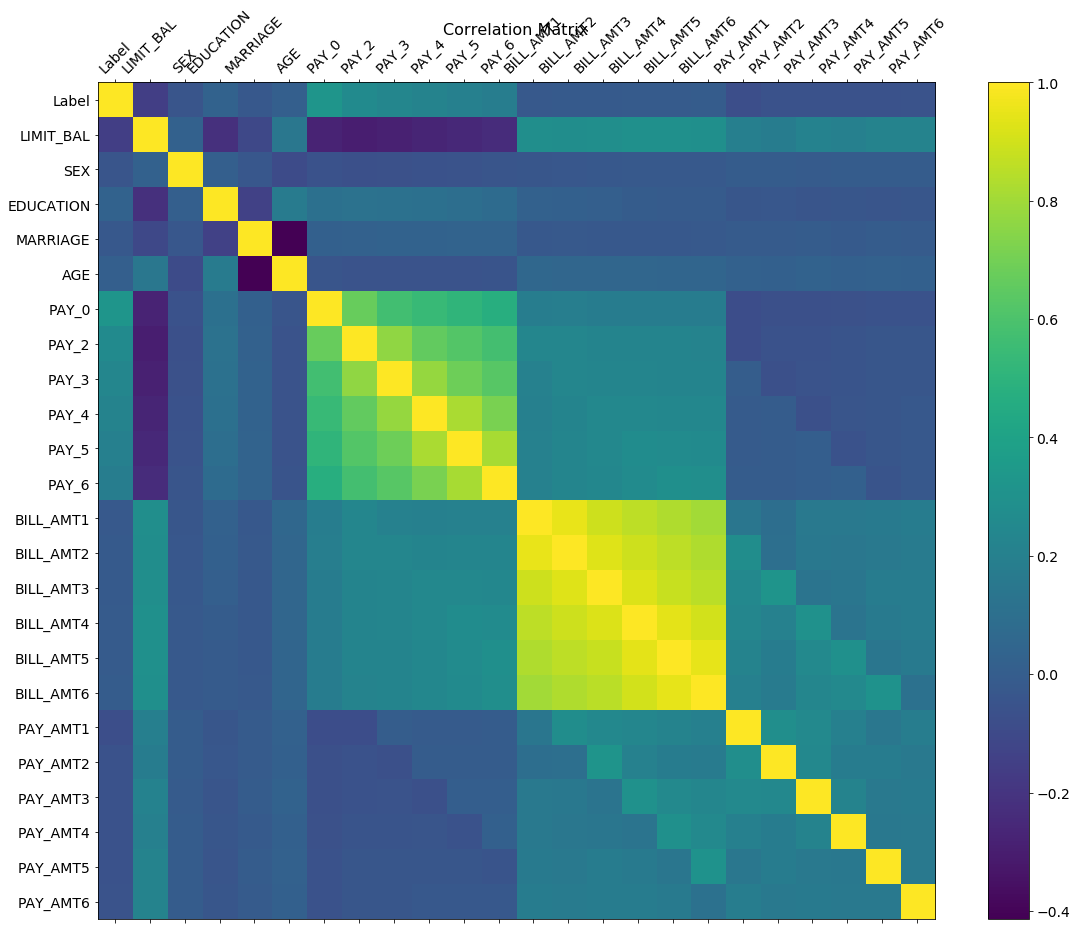

In [11]:
## Corr plot
f = plt.figure(figsize=(19, 15))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=45)
plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

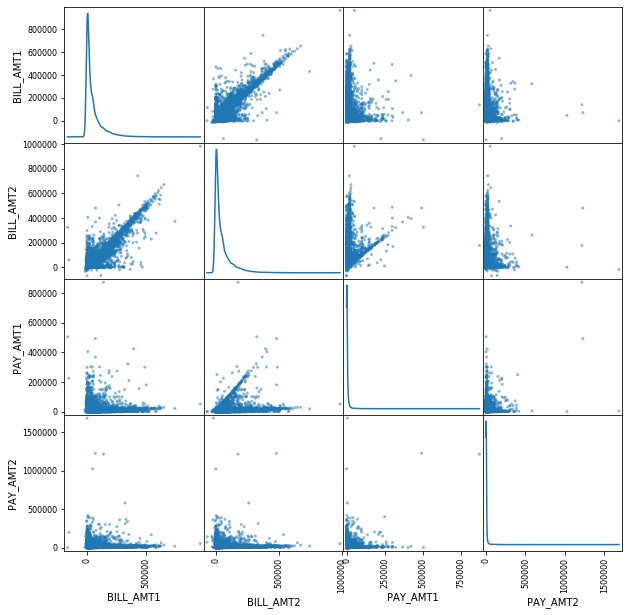

In [12]:
from pandas.plotting import scatter_matrix
SCAT_COLUMNS = ['BILL_AMT1', 'BILL_AMT2', 'PAY_AMT1', 'PAY_AMT2']
scatter_matrix(data[SCAT_COLUMNS],figsize=(10, 10), diagonal ='kde')
plt.show()

### Step 4: Secure Feature Processing pipeline using SageMaker Processing

While you can pre-process small amounts of data directly in a notebook SageMaker Processing offloads the heavy lifting of pre-processing larger datasets by provisioning the underlying infrastructure, downloading the data from an S3 location to the processing container, running the processing scripts, storing the processed data in an output directory in Amazon S3 and deleting the underlying transient resources needed to run the processing job. Once the processing job is complete, the infrastructure used to run the job is wiped, and any temporary data stored on it is deleted.

In [13]:
if not os.path.exists('rawdata/rawdata.csv'):
    !mkdir rawdata
    data.to_csv('rawdata/rawdata.csv', index=None)
else:
    pass

In [14]:
#Upload the raw dataset
raw_data_location = sess.upload_data('rawdata', bucket=rawbucket, key_prefix=dataprefix)
print(raw_data_location)

s3://sagemaker-us-west-2-389535300735/sagemaker-studio-byoc/data


In [15]:
## Use SageMaker Processing with Sk Learn. -- combine data into train and test at this stage if possible.
from sagemaker.sklearn.processing import SKLearnProcessor
sklearn_processor = SKLearnProcessor(framework_version='0.20.0',
                                     role=role,
                                     instance_type='ml.c4.xlarge',
                                     instance_count=1) 

### Write a preprocessing script (same as above)

In [16]:
%%writefile preprocessing.py

import argparse
import os
import warnings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.exceptions import DataConversionWarning
from sklearn.compose import make_column_transformer

warnings.filterwarnings(action='ignore', category=DataConversionWarning)

if __name__=='__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--train-test-split-ratio', type=float, default=0.3)
    parser.add_argument('--random-split', type=int, default=0)
    args, _ = parser.parse_known_args()
    
    print('Received arguments {}'.format(args))

    input_data_path = os.path.join('/opt/ml/processing/input', 'rawdata.csv')
    
    print('Reading input data from {}'.format(input_data_path))
    df = pd.read_csv(input_data_path)
    df.sample(frac=1)
    
    COLS = df.columns
    newcolorder = ['PAY_AMT1','BILL_AMT1'] + list(COLS[1:])[:11] + list(COLS[1:])[12:17] + list(COLS[1:])[18:]
    
    split_ratio = args.train_test_split_ratio
    random_state=args.random_split
    
    X_train, X_test, y_train, y_test = train_test_split(df.drop('Label', axis=1), df['Label'], 
                                                        test_size=split_ratio, random_state=random_state)
    
    preprocess = make_column_transformer(
        (['PAY_AMT1'], StandardScaler()),
        (['BILL_AMT1'], MinMaxScaler()),
    remainder='passthrough')
    
    print('Running preprocessing and feature engineering transformations')
    train_features = pd.DataFrame(preprocess.fit_transform(X_train), columns = newcolorder)
    test_features = pd.DataFrame(preprocess.transform(X_test), columns = newcolorder)
    
    # concat to ensure Label column is the first column in dataframe
    train_full = pd.concat([pd.DataFrame(y_train.values, columns=['Label']), train_features], axis=1)
    test_full = pd.concat([pd.DataFrame(y_test.values, columns=['Label']), test_features], axis=1)
    
    print('Train data shape after preprocessing: {}'.format(train_features.shape))
    print('Test data shape after preprocessing: {}'.format(test_features.shape))
    
    train_features_headers_output_path = os.path.join('/opt/ml/processing/train_headers', 'train_data_with_headers.csv')
    
    train_features_output_path = os.path.join('/opt/ml/processing/train', 'train_data.csv')
    
    test_features_output_path = os.path.join('/opt/ml/processing/test', 'test_data.csv')
    
    print('Saving training features to {}'.format(train_features_output_path))
    train_full.to_csv(train_features_output_path, header=False, index=False)
    print("Complete")
    
    print("Save training data with headers to {}".format(train_features_headers_output_path))
    train_full.to_csv(train_features_headers_output_path, index=False)
                 
    print('Saving test features to {}'.format(test_features_output_path))
    test_full.to_csv(test_features_output_path, header=False, index=False)
    print("Complete")
    

Writing preprocessing.py


In [17]:
# Copy the preprocessing code over to the s3 bucket
codeprefix = prefix + '/code'
codeupload = sess.upload_data('preprocessing.py', bucket=rawbucket, key_prefix=codeprefix)
print(codeupload)

s3://sagemaker-us-west-2-389535300735/sagemaker-studio-byoc/code/preprocessing.py


In [18]:
train_data_location = rawbucket + '/' + traindataprefix
test_data_location = rawbucket+'/'+testdataprefix
print("Training data location = {}".format(train_data_location))
print("Test data location = {}".format(test_data_location))

Training data location = sagemaker-us-west-2-389535300735/sagemaker-studio-byoc/train_data
Test data location = sagemaker-us-west-2-389535300735/sagemaker-studio-byoc/test_data


In [19]:
from sagemaker.processing import ProcessingInput, ProcessingOutput

sklearn_processor.run(code=codeupload,
                      inputs=[ProcessingInput(
                        source=raw_data_location,
                        destination='/opt/ml/processing/input')],
                      outputs=[ProcessingOutput(output_name='train_data',
                                                source='/opt/ml/processing/train',
                               destination='s3://' + train_data_location),
                               ProcessingOutput(output_name='test_data',
                                                source='/opt/ml/processing/test',
                                               destination="s3://"+test_data_location),
                               ProcessingOutput(output_name='train_data_headers',
                                                source='/opt/ml/processing/train_headers',
                                               destination="s3://" + rawbucket + '/' + prefix + '/train_headers')],
                      arguments=['--train-test-split-ratio', '0.2']
                     )

preprocessing_job_description = sklearn_processor.jobs[-1].describe()

output_config = preprocessing_job_description['ProcessingOutputConfig']
for output in output_config['Outputs']:
    if output['OutputName'] == 'train_data':
        preprocessed_training_data = output['S3Output']['S3Uri']
    if output['OutputName'] == 'test_data':
        preprocessed_test_data = output['S3Output']['S3Uri']

INFO:sagemaker:Creating processing-job with name sagemaker-scikit-learn-2020-08-18-21-35-41-141



Job Name:  sagemaker-scikit-learn-2020-08-18-21-35-41-141
Inputs:  [{'InputName': 'input-1', 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-389535300735/sagemaker-studio-byoc/data', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-389535300735/sagemaker-studio-byoc/code/preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'train_data', 'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-389535300735/sagemaker-studio-byoc/train_data', 'LocalPath': '/opt/ml/processing/train', 'S3UploadMode': 'EndOfJob'}}, {'OutputName': 'test_data', 'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-389535300735/sagemaker-studio-byoc/test_data', 'LocalPath': '/opt/ml/

# Part 2: Building the Container and Training the model


### Step 5: Set up SageMaker Experiments

In this notebook, we first build the Docker image by providing the Dockerfile discussed before and train a model using that Dockerfile

We use SageMaker Experiments for data scientists to track the lineage of the model from the raw data source to the preprocessing steps and the model training pipeline. With SageMaker Experiments, data scientists can compare, track and manage multiple diferent model training jobs, data processing jobs, hyperparameter tuning jobs and retain a lineage from the source data to the training job artifacts to the model hyperparameters and any custom metrics that they may want to monitor as part of the model training.


In [20]:
# Create a SageMaker Experiment
cc_experiment = Experiment.create(
    experiment_name=f"CreditCardDefault-{int(time.time())}", 
    description="Predict credit card default from payments data", 
    sagemaker_boto_client=sm)
print(cc_experiment)


Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f40b5f7e4d0>,experiment_name='CreditCardDefault-1597786793',description='Predict credit card default from payments data',tags=None,experiment_arn='arn:aws:sagemaker:us-west-2:389535300735:experiment/creditcarddefault-1597786793',response_metadata={'RequestId': 'cd808404-28f9-4467-8326-6a01bdb491c0', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'cd808404-28f9-4467-8326-6a01bdb491c0', 'content-type': 'application/x-amz-json-1.1', 'content-length': '100', 'date': 'Tue, 18 Aug 2020 21:39:53 GMT'}, 'RetryAttempts': 0})


In addition to training, we want to track the lineage of the entire machine learing pipeline also including the processing job above. 

In [21]:
# Start Tracking parameters used in the Pre-processing pipeline.
with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters({
        "train_test_split_ratio": 0.2,
        "random_state":0
    })
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="ccdefault-raw-dataset", media_type="s3/uri", value=raw_data_location)
    tracker.log_input(name="ccdefault-train-dataset", media_type="s3/uri", value=train_data_location)
    tracker.log_input(name="ccdefault-test-dataset", media_type="s3/uri", value=test_data_location)
    

### Step 6: Build XgBoost container for training

The code for the XGB container is already supplied with this notebook. We simply need to build this container and push it to ECR. The single line of code below will do it.

In [22]:
!sm-docker build .

...[Container] 2020/08/18 21:40:41 Waiting for agent ping

[Container] 2020/08/18 21:40:43 Waiting for DOWNLOAD_SOURCE
[Container] 2020/08/18 21:40:50 Phase is DOWNLOAD_SOURCE
[Container] 2020/08/18 21:40:50 CODEBUILD_SRC_DIR=/codebuild/output/src584663887/src
[Container] 2020/08/18 21:40:50 YAML location is /codebuild/output/src584663887/src/buildspec.yml
[Container] 2020/08/18 21:40:50 Processing environment variables
[Container] 2020/08/18 21:40:51 No runtime version selected in buildspec.
[Container] 2020/08/18 21:40:51 Moving to directory /codebuild/output/src584663887/src
[Container] 2020/08/18 21:40:51 Registering with agent
[Container] 2020/08/18 21:40:51 Phases found in YAML: 3
[Container] 2020/08/18 21:40:51  PRE_BUILD: 2 commands
[Container] 2020/08/18 21:40:51  BUILD: 4 commands
[Container] 2020/08/18 21:40:51  POST_BUILD: 3 commands
[Container] 2020/08/18 21:40:51 Phase complete: DOWNLOAD_SOURCE State: SUCCEEDED
[Container] 2020/08/18 21:40:51 Phase context status code:  M

### Step 7: Train the Model

The same security postures we applied previously during SM Processing apply to training jobs. We will also have SageMaker experiments track the training job and store metadata such as model artifact location, training/validation data location, model hyperparameters etc.

As shown above, your image URI has the following form:
Image URI: {account-id}.dkr.ecr.{region}.amazonaws.com/sagemaker-studio-{studioID}:{user-name}


In [23]:
account = sess.boto_session.client('sts').get_caller_identity()['Account']
ecr = boto3.client('ecr')
domain_id = 'sagemaker-studio-{}'.format(sm.list_apps()['Apps'][0]['DomainId'])
image_tag = ecr.list_images(repositoryName=domain_id, filter={
        'tagStatus': 'TAGGED'
    })['imageIds'][0]['imageTag']
image = '{}.dkr.ecr.{}.amazonaws.com/{}:{}'.format(account, region, domain_id, image_tag)
preprocessing_trial_component = tracker.trial_component

trial_name = f"cc-fraud-training-job-{int(time.time())}"
cc_trial = Trial.create(
        trial_name=trial_name, 
            experiment_name=cc_experiment.experiment_name,
        sagemaker_boto_client=sm
    )

cc_trial.add_trial_component(preprocessing_trial_component)
cc_training_job_name = "cc-training-job-{}".format(int(time.time()))

xgb = sagemaker.estimator.Estimator(image,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.c4.xlarge',
                                    train_max_run=86400,
                                    output_path='s3://{}/{}/models'.format(rawbucket, prefix),
                                    sagemaker_session=sess) # set to true for distributed training

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        verbosity=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit(inputs = {'training':"s3://" + train_data_location},
       job_name=cc_training_job_name,
        experiment_config={
            "TrialName": cc_trial.trial_name, #log training job in Trials for lineage
            "TrialComponentDisplayName": "Training",
        },
        wait=True,
    )

INFO:sagemaker:Creating training-job with name: cc-training-job-1597787144


2020-08-18 21:45:44 Starting - Starting the training job...
2020-08-18 21:45:56 Starting - Launching requested ML instances......
2020-08-18 21:46:56 Starting - Preparing the instances for training...
2020-08-18 21:47:40 Downloading - Downloading input data
2020-08-18 21:47:40 Stopping - Stopping the training job
2020-08-18 21:47:40 Stopped - Training job stopped
..Training seconds: 1
Billable seconds: 1


Having used SageMaker Experiments to track the training runs, we can now extract model metadata to get the entire lineage of the model from the source data to the model artifacts and the hyperparameters.

To do this, simply call the **describe_trial_component** API.

In [24]:
# Present the Model Lineage as a dataframe
from sagemaker.session import Session
session = boto3.Session()
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(session, sm), 
    search_expression={
        "Filters":[{
            "Name": "Parents.TrialName",
            "Operator": "Equals",
            "Value": trial_name
        }]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)
lineagedf= lineage_table.dataframe()

lineagedf

,TrialComponentName,DisplayName,random_state,train_test_split_ratio,ccdefault-raw-dataset - MediaType,ccdefault-raw-dataset - Value,ccdefault-test-dataset - MediaType,ccdefault-test-dataset - Value,ccdefault-train-dataset - MediaType,ccdefault-train-dataset - Value,...,eta,gamma,max_depth,min_child_weight,num_round,objective,subsample,verbosity,training - MediaType,training - Value
0,TrialComponent-2020-08-18-213954-puak,Preprocessing,0.0,0.2,s3/uri,s3://sagemaker-us-west-2-389535300735/sagemake...,s3/uri,sagemaker-us-west-2-389535300735/sagemaker-stu...,s3/uri,sagemaker-us-west-2-389535300735/sagemaker-stu...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cc-training-job-1597787144-aws-training-job,Training,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.2,4.0,5.0,6.0,100.0,binary:logistic,0.8,0.0,NaN,s3://sagemaker-us-west-2-389535300735/sagemake...


In [25]:
# get detailed information about a particular trial
sm.describe_trial_component(TrialComponentName=lineagedf.TrialComponentName[1])

{'TrialComponentName': 'cc-training-job-1597787144-aws-training-job',
 'TrialComponentArn': 'arn:aws:sagemaker:us-west-2:389535300735:experiment-trial-component/cc-training-job-1597787144-aws-training-job',
 'DisplayName': 'Training',
 'Source': {'SourceArn': 'arn:aws:sagemaker:us-west-2:389535300735:training-job/cc-training-job-1597787144',
  'SourceType': 'SageMakerTrainingJob'},
 'Status': {'PrimaryStatus': 'Stopped',
  'Message': 'Status: Stopped, secondary status: Stopped, failure reason: .'},
 'StartTime': datetime.datetime(2020, 8, 18, 21, 47, 40, tzinfo=tzlocal()),
 'EndTime': datetime.datetime(2020, 8, 18, 21, 47, 40, tzinfo=tzlocal()),
 'CreationTime': datetime.datetime(2020, 8, 18, 21, 45, 45, 133000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-west-2:389535300735:user-profile/d-48g3khunwolj/stefan-main-user',
  'UserProfileName': 'stefan-main-user',
  'DomainId': 'd-48g3khunwolj'},
 'LastModifiedTime': datetime.datetime(2020, 8, 18, 21, 47, 41,

# Part 3: Using the trained model for inference

### Step 8: Inference using Batch Transform

Let's first use Batch Transform to generate inferences for the test dataset you pre-processed before. 


In [26]:
s3 = boto3.client('s3')
s3.download_file(rawbucket, testdataprefix + '/test_data.csv', 'test_data.csv')

In [27]:
newcolorder = ['PAY_AMT1','BILL_AMT1'] + list(COLS[1:])[:11] + list(COLS[1:])[12:17] + list(COLS[1:])[18:]

test_full = pd.read_csv('test_data.csv', names= ['Label'] + newcolorder)
test_full.head()

,Label,PAY_AMT1,BILL_AMT1,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,...,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0,-0.341476,0.201175,20000.0,1.0,1.0,2.0,33.0,1.0,2.0,...,17399.0,19057.0,18453.0,19755.0,19288.0,2260.0,0.0,1600.0,0.0,644.0
1,0,-0.136859,0.199594,20000.0,2.0,2.0,2.0,35.0,0.0,0.0,...,19347.0,18600.0,19000.0,19000.0,20000.0,0.0,1000.0,0.0,1000.0,0.0
2,0,-0.284364,0.185736,230000.0,2.0,1.0,1.0,44.0,1.0,-1.0,...,949.0,2864.0,933.0,0.0,0.0,2873.0,933.0,0.0,0.0,0.0
3,0,-0.040569,0.289360,100000.0,1.0,2.0,1.0,42.0,0.0,0.0,...,99998.0,16138.0,17758.0,18774.0,20272.0,2000.0,2000.0,2000.0,2000.0,2000.0
4,0,0.079132,0.186502,150000.0,1.0,1.0,2.0,29.0,-2.0,-2.0,...,6917.0,831.0,6469.0,5138.0,7810.0,833.0,6488.0,5153.0,7833.0,7130.0


In [28]:
test_data_no_label = test_full.drop(columns = ['Label'], axis=1)
label = test_full['Label']
test_data_no_label.to_csv('test_data_no_label.csv', index=False, header=False)
test_data_no_label.shape

(6000, 23)

In [29]:
sess = sagemaker.Session()
test_data_nohead_location = sess.upload_data('test_data_no_label.csv', bucket=rawbucket, key_prefix=testdatanolabelprefix)

In [30]:
%%time

sm_transformer = xgb.transformer(1, 'ml.m5.xlarge', accept = 'text/csv')

# start a transform job
sm_transformer.transform(test_data_nohead_location, split_type='Line', content_type='text/csv')
sm_transformer.wait()

KeyError: 'ModelArtifacts'

In [33]:
import json
import io
from urllib.parse import urlparse

def get_csv_output_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:]
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket_name, '{}/{}'.format(prefix, file_name))
    return obj.get()["Body"].read().decode('utf-8')

In [34]:
output = get_csv_output_from_s3(sm_transformer.output_path, 'test_data_no_label.csv.out')
output_df = pd.read_csv(io.StringIO(output), sep=",", header=None)
output_df.head(8)

NameError: name 'sm_transformer' is not defined

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [36]:
1- np.unique(data['Label'], return_counts=True)[1][1]/(len(data['Label']))

0.7787999999999999

In [37]:
print("Baseline Accuracy = {}".format(1- np.unique(data['Label'], return_counts=True)[1][1]/(len(data['Label']))))
print("Accuracy Score = {}".format(accuracy_score(label, output_df)))

Baseline Accuracy = 0.7787999999999999


NameError: name 'output_df' is not defined

In [38]:
output_df['Predicted']=output_df.values
output_df['Label'] = label
confusion_matrix = pd.crosstab(output_df['Predicted'], output_df['Label'], rownames=['Actual'], colnames=['Predicted'], margins = True)
confusion_matrix

NameError: name 'output_df' is not defined

### Step 9: Conclusions

In this notebook we used SageMaker Processing, SageMaker Training by Bringing your own XGB container and SageMaker Batch Transform for inference. In all these cases, SageMaker sets up and tears down the instance once the job is completed. 

Remember to delete your datasets in the Amazon S3 bucket you used for this notebook.